This module creates clusters based on product names

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Silhouette Score for 10 clusters: 0.7457377314567566


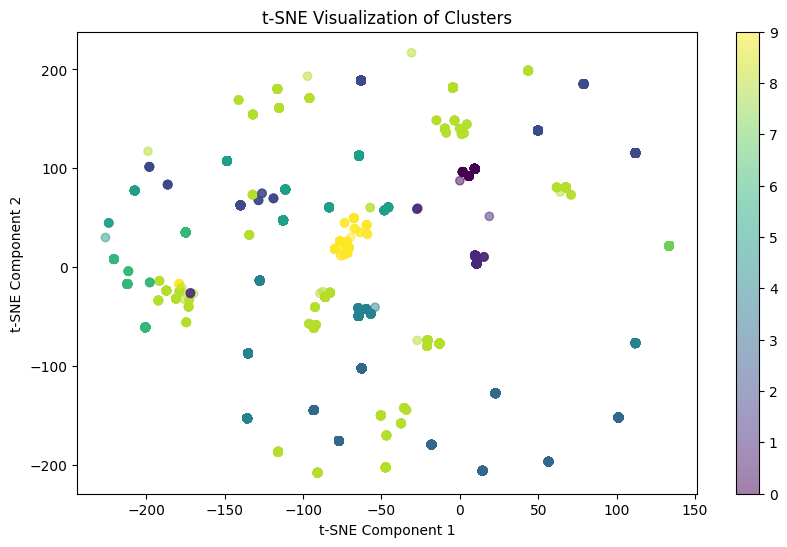

In [6]:
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load the dataset
filtered_df = pd.read_csv('filtered_data_with_predictions.csv')
texts = filtered_df['name'].astype(str).tolist()

# Encode product names with SBERT
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_tensor=True)

# Normalize embeddings for KMeans
embeddings_normalized = normalize(embeddings.cpu().detach().numpy())

# Define number of clusters
# This was decided after iterating over having 2 to 10 clusters.
# 10 clusters yeild best results with current configuration
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings_normalized)

# Add cluster labels to DataFrame
filtered_df['cluster'] = kmeans.labels_

# Add appearances column for frequency of each name within its cluster
filtered_df['appearances'] = filtered_df.groupby(['cluster', 'name'])['name'].transform('count')

# Evaluate Clustering with Silhouette Score
if num_clusters > 1:
    score = silhouette_score(embeddings_normalized, kmeans.labels_)
    print(f"Silhouette Score for {num_clusters} clusters: {score}")

# Visualize clusters with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings_normalized)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Save clustered data to CSV for further analysis
filtered_df.to_csv('filtered_data_predictions_clusters.csv', index=False)



Better visual inspection to see how many unique products are there in each cluster, and how ofthen they appear.

In [ ]:
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}:")
    cluster_data = filtered_df[filtered_df['cluster'] == cluster_num]

    # Count unique product names within the cluster
    unique_names = cluster_data['name'].value_counts()

    # Print the number of unique names and the names themselves with their counts
    print(f"Number of unique names in Cluster {cluster_num}: {unique_names.shape[0]}")
    print(unique_names.head(10).to_string())  # Display top 10 for brevity; adjust as needed


Cluster 0:
Number of unique names in Cluster 0: 1
name
amazon tap smart assistant alexaenabled black brand new    601

Cluster 1:
Number of unique names in Cluster 1: 3
name
amazonbasics aaa performance alkaline batteries 36 count                   8339
amazonbasics doubledoor folding metal dog crate  medium 36x23x25 inches       2
amazonbasics singledoor folding metal dog crate  large 42x28x30 inches        1

Cluster 2:
Number of unique names in Cluster 2: 7
name
fire tablet with alexa 7 display 16 gb blue  with special offers                                 987
allnew fire hd 8 tablet with alexa 8 hd display 16 gb marine blue  with special offers           883
allnew fire hd 8 tablet with alexa 8 hd display 32 gb marine blue  with special offers           160
allnew fire 7 tablet with alexa 7 display 8 gb  marine blue                                       82
certified refurbished amazon fire tv with alexa voice remote                                       5
amazon fire tv with 4k u